# Treinamento de Rede Neural com SNR aleatório

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-03-01 23:37:02.701119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 23:37:03.817411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 23:37:03.817456: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-01 23:37:03.964315: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 23:37:06.207684: W tensorflow/stream_executor/platform/de

In [2]:
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'PSK'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 8      # PSK modulation

In [3]:
def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[0])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)

    if scaler is not None:
        x = scaler(np.concatenate((x, np.array([channel_output[1]]).T), axis=1))
    else:
        x = np.concatenate((x, np.array([channel_output[1]]).T), axis=1)
    
    x = x.reshape(1,-1,3)
    
    for i in range(1, len(SNR_dB)):
        a, b, c = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.stack([np.real(c[0][:]), np.imag(c[0][:])], axis=1)
        
        if scaler is not None:
            d = scaler(np.concatenate((d, np.array([c[1]]).T), axis=1))
        else:
            d = np.concatenate((d, np.array([c[1]]).T), axis=1)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_output = np.vstack((channel_output, c))
        x = np.vstack((x, d.reshape(1,-1,3)))
    
    y = np.float_(indices)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [40]:
def Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, min, max):
    
    indices = np.array([])
    symbs = np.array([])
    channel_output = np.array([])
    alpha = np.array([])
    for i in range(total_num_symbols):
        a, b, c = Model(Mod, 1, M, channel_type, Es, code_rate, np.random.randint(min, max))
        symbs = np.append(symbs, a)
        indices = np.append(indices, b)
        channel_output = np.append(channel_output, c[0])
        alpha = np.append(alpha, c[1])
        
    x = np.stack([np.real(channel_output[:]),
                        np.imag(channel_output[:])], axis=1)
    x = np.concatenate((x, np.array([alpha]).T), axis=1)
    
    y = np.float_(indices)
    
    return x, y, np.array(symbs)

In [ ]:
x_out, y_out, symbs = Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, 5, 30)

In [39]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by StandardScaler.

In [38]:
plot_symbols(X_train, y_train, M, symbs)

NameError: name 'X_train' is not defined

## Criação e treinamento da Rede Neural

In [47]:
n_inputs = np.shape(X_train)[1]
n_hidden1 = 150
n_hidden2 = 80
n_hidden3 = 50

n_outputs = M
learning_rate = 0.01
n_epochs = 10
batch_size = 800

y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2023-02-28 23:45:14.755046: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36000000 exceeds 10% of free system memory.
2023-02-28 23:45:14.877789: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36000000 exceeds 10% of free system memory.


### Usando API Keras

In [ ]:
inputs = tf.keras.Input(shape=(3,))

x = tf.keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="glorot_normal")(inputs)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden3, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)


output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)
#output = tf.keras.layers.BatchNormalization(momentum=0.99)(output)

In [11]:
model_PSK.append(tf.keras.Model(inputs=inputs, outputs=output))

model_PSK.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
             metrics=["accuracy"])

history = model_PSK.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True)

tests_score = model_PSK.evaluate(X_test, y_test)
print("\nTest loss:", tests_score[0])
print("Test accuracy:", tests_score[1])
print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3418 - accuracy: 0.8950
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2429 - accuracy: 0.9075
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2338 - accuracy: 0.9077
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2310 - accuracy: 0.9074
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2301 - accuracy: 0.9076
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2296 - accuracy: 0.9076
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2294 - accuracy: 0.9076
Epoch 8/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2292 - accuracy: 0.9077
Epoch 9/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2291 - accuracy: 0.9076
Epoch 10/10
15625/15625 [==============================] - 16s 999us/step - loss: 0.2281 - accuracy:

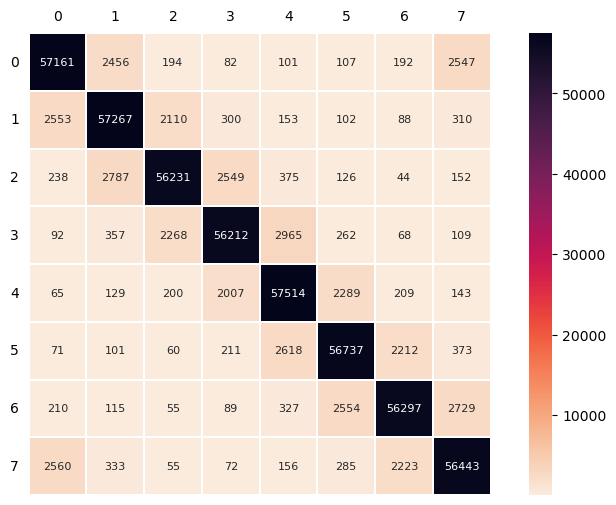

In [12]:
plot_confusion_matrix(M, X_test, y_test, M, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### PSK | Rayleigh

In [13]:
Mod = "PSK"
channel_type = "rayleigh"
M = 8
init_scale = 2
interval = 50
passo = 4

In [14]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [15]:
amostras = [conjunto(Mod, int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [16]:
error_rate = ([ser(model_PSK, tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))]) / (tf.math.log(float(M))/tf.math.log(2.))

In [17]:
error_rate

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([0.19357884, 0.12729658, 0.07454129, 0.03531634, 0.01536021,
       0.00848725, 0.00330229, 0.00143234, 0.00086814, 0.00055239,
       0.00047485, 0.00042646, 0.0004172 ], dtype=float32)>

In [18]:
np.mean(error_rate - Teo_SNRs)

-1.049646e-05

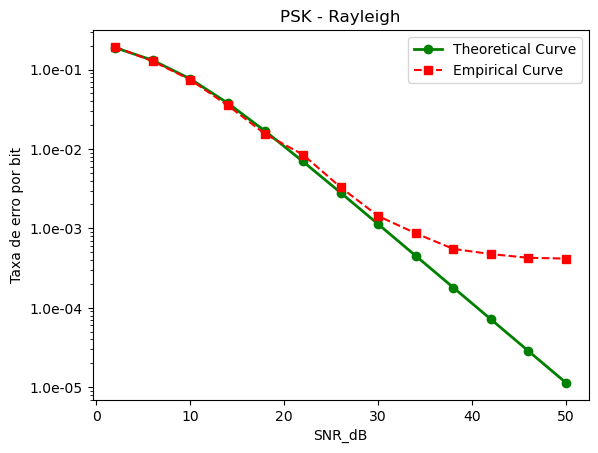

In [19]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('8-PSK - Rayleigh')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

### PSK | AWGN

In [20]:
Mod = 'PSK'
channel_type = 'awgn'
interval = 17
init_scale = 2
passo = 2

In [21]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [22]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, init_scale + i, False, scaler.transform) for i in range(0, interval, passo)]

In [23]:
error_rate = ([ser(model_PSK, tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))]) / (tf.math.log(float(M))/tf.math.log(2.))

In [24]:
error_rate

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([1.4942528e-01, 1.3020833e-01, 8.4033616e-02, 5.8652729e-02,
       3.3652451e-02, 9.4643785e-03, 2.2266756e-03, 2.0005960e-04,
       5.5506148e-06], dtype=float32)>

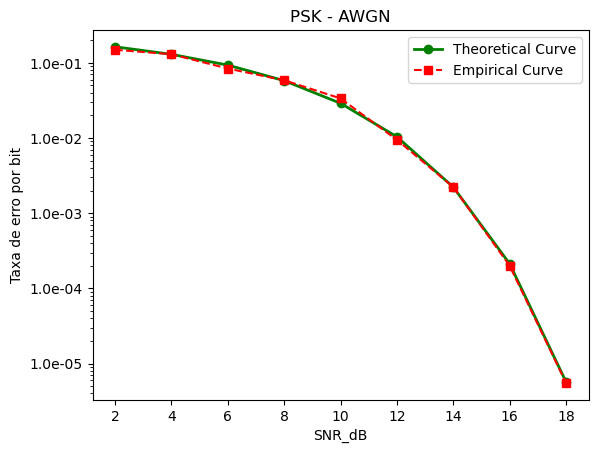

In [25]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('8-PSK - AWGN')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

## Modelo QAM

In [26]:
Mod = "QAM"
channel_type = "rayleigh"
M = 16

In [27]:
x_out, y_out, symbs = Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, 5, 30)

In [28]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Criação e treinamento da Rede Neural

In [30]:
n_inputs = np.shape(X_train)[1]
#n_hidden1 = 300
n_hidden1 = 150
n_hidden2 = 80
n_hidden3 = 50

n_outputs = M
learning_rate = 0.001
n_epochs = 10
batch_size = 800

y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

### Usando API Keras

In [31]:
inputs = tf.keras.Input(shape=(3,))

x = tf.keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="glorot_normal")(inputs)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden3, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

#x = tf.keras.layers.Dense(n_hidden4, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)
#output = tf.keras.layers.BatchNormalization(momentum=0.99)(output)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 150)               600       
                                                                 
 dense_5 (Dense)             (None, 80)                12080     
                                                                 
 dense_6 (Dense)             (None, 50)                4050      
                                                                 
 dense_7 (Dense)             (None, 16)                816       
                                                                 
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_QAM = tf.keras.Model(inputs=inputs, outputs=output)

model_QAM.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
             metrics=["accuracy"])

history = model_QAM.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True)

tests_score = model_QAM.evaluate(X_test, y_test)
print("\nTest loss:", tests_score[0])
print("Test accuracy:", tests_score[1])
print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6135 - accuracy: 0.7954
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4500 - accuracy: 0.8340
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4483 - accuracy: 0.8344
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4475 - accuracy: 0.8344
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4470 - accuracy: 0.8341
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4468 - accuracy: 0.8344
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4462 - accuracy: 0.8342
Epoch 8/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4459 - accuracy: 0.8343
Epoch 9/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4457 - accuracy: 0.8347
Epoch 10/10
15625/15625 [==============================] - 16s 1ms/step - loss: 0.4394 - accuracy: 0

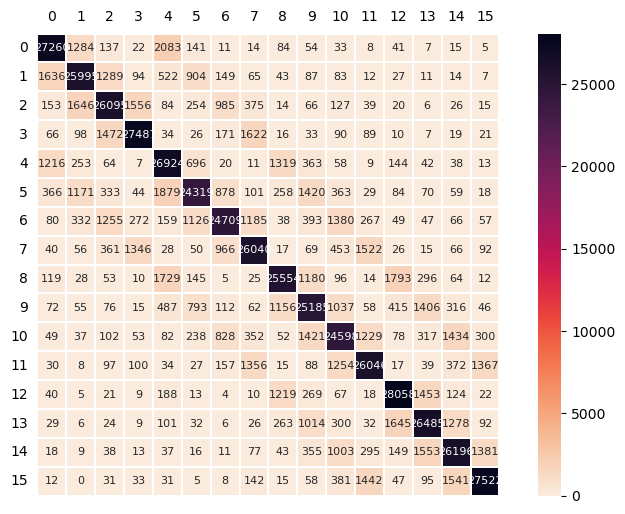

In [33]:
plot_confusion_matrix(M, X_test, y_test, M, nn=True)
#plot_decision_boundary(modelQ, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelQ, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | Rayleigh

In [34]:
Mod = 'QAM'
channel_type = 'rayleigh'
M = 16
init_scale = 2
interval = 48
passo = 4

In [35]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [36]:
amostras = [conjunto(Mod, int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, init_scale + i, False, scaler.transform) for i in range(0, interval, passo)]

In [37]:
error_rate = ([ser(model_QAM, tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))]) / (tf.math.log(float(M))/tf.math.log(2.))

In [38]:
error_rate

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([0.17772512, 0.1254386 , 0.08681319, 0.05295139, 0.0231383 ,
       0.01022599, 0.00543227, 0.0034244 , 0.00258622, 0.00238936,
       0.00235196, 0.00226027], dtype=float32)>

In [39]:
np.mean(error_rate - Teo_SNRs)

-0.0108103715

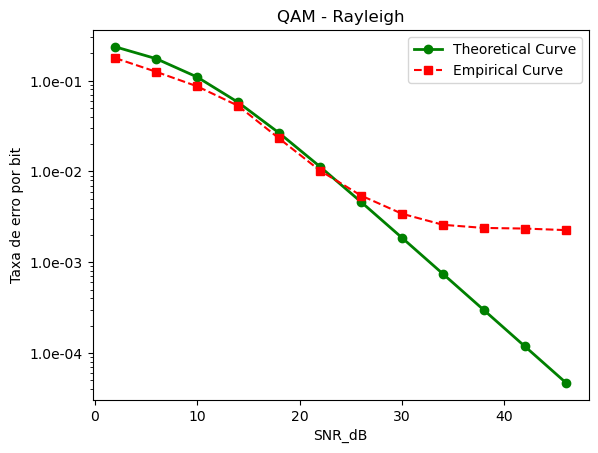

In [40]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('16-QAM - Rayleigh')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

### QAM | AWGN

In [41]:
Mod = 'QAM'
channel_type = 'awgn'
init_scale = 2
interval = 19
passo = 2

In [42]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [43]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, init_scale + i, False, scaler.transform) for i in range(0, interval, passo)]

In [44]:
error_rate = ([ser(model_QAM, tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))]) / (tf.math.log(float(M))/tf.math.log(2.))

In [45]:
error_rate

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.7905405e-01, 1.6272189e-01, 1.2379808e-01, 8.8652484e-02,
       5.8888890e-02, 2.7352298e-02, 9.9405423e-03, 1.8416536e-03,
       1.7465599e-04, 4.9659648e-06], dtype=float32)>

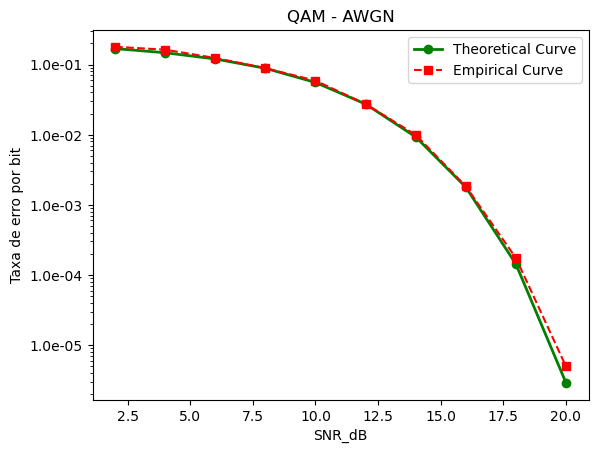

In [46]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('16-QAM - AWGN')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()